# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework 9
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, April 7th, 2018 at 10:59am

**Instructions:**

- Upload your final answers as an iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

This Homework is a continuation of Problem #1 from Homework 8.

Your answers to Problem #1 from HW8 should  give you a idea of how one might create or select a model for a particular application and your answers will help you with formalizing the model in this Homework, which is much more technically involved.


## Problem #1: Modeling Your Understanding

In the dataset "reviews_processed.csv", you'll find a database of Yelp reviews for a number of restaurants. These reviews have already been processed and transformed by someone who has completed the (pre) modeling process described in Problem #1. That is, imagine the dataset in "reviews_processed.csv" is the result of feeding the raw Yelp reviews through the pipeline someone built for Problem #1.

The following is a full list of columns in the dataset and their meanings:

I. Relevant to Part A and B:

  1. "review_id" - the unique identifier for each Yelp review
  2. "topic" - the subject addressed by the review (0 stands for food and 1 stands for service)
  3. "rid" - the unique identifier for each restaurant
  4. "count" - the number of sentences in a particular review on a particular topic
  5. "mean" - the probability of a sentence in a particular review on a particular topic being positive, averaged over total number of sentences in the review related to that topic.
  6. "var" - the variance of the probability of a sentence in a particular review on a particular topic being positive, taken over all sentences in the review related to that topic.

II. Relevant (possibly) to Extra Credit:

  1. "uavg" - the average star rating given by a particular reviewer (taken across all their reviews)
  2. "stars" - the number of stars given in a particular review
  3. "max" - the max probability of a sentence in a particular review on a particular topic being positive
  4. "min" - the min probability of a sentence in a particular review on a particular topic being positive

The following schema illustrates the model of the raw data that is used to generate "reviews_processed.csv":
<img src="restuarant_model.png">

***Warning:*** *this is a "real" data science problem in the sense that the dataset in "reviews_processed.csv" is large. We understand that a number of you have limited computing resources, so you are encouraged but not required to use the entire dataset. If you wish you may use 10 restaurants from the dataset, as long as your choice of 10 contains a couple of restaurants with a large number of reviews and a couple with a small number of reviews.*

### Part A: Modeling

When the value in "count" is low, the "mean" value can be very skewed.

Following the [SAT prep school example discussed in lab](https://am207.github.io/2018spring/wiki/gelmanschoolstheory.html) (and using your answers for HW 8 Problem #1), set up a Bayesian model(that is, write functions encapsulating the pymc3 code) for a reviewer $j$'s opinion of restaurant $k$'s food and service, separately. That is, you will have a model for each restaurant and each aspect (food and serivce). For restaurant $k$, you will have a model for $\{\theta_{jk}^{\text{food}}\}$ and one for $\{\theta_{jk}^{\text{service}}\}$, where $\theta_{jk}$ is the positivity of the opinion of the $j$-th reviewer regarding the $k$-th restaurant. 

**Hint:** what quantity in our data naturally corresponds to $\bar{y}_j$'s in the prep school example? How would you calculate the parameter $\sigma_j^2$ in the distribution of $\bar{y}_j$ (note that, contrary to the school example, $\sigma_j^2$ is not provided explictly in the restaurant data)?

### Part B: Analysis for Each restaurant

Use your model to produce estimates for $\theta_{jk}$'s. Pick a few restaurants, for each aspect ("food" and "service") of each restaurant, plot your estimates for the $\theta$'s against the values in the "mean" column (corresponding to this restaurant). 

For the same restaurants, for each aspect, generate shrinkage plots and probability shrinkage plots as follows:

**Shrinkage plot for a restaurant, topic**:

The aim for this plot is to see the shrinkage from sample means (error bars generated from standard error) to $\theta_{jk}$'s (error bars generated from theta variance).  

The sample means of reviews are plotted at $y=0$ and the posterior means ($\theta_{ik}$) are plotted at $y=1$. For each review connect the sample mean to the posterior mean with a line.  Show error bars on the sample mean points using standard error and on the ($\theta_{jk}$) points using variance.

**Probability Shrinkage plot for a restaurant, topic**:

The aim for this plot is to see the shrinkage from the classification probabilities from the sample means of reviews to the classification probabilities of $\theta_{jk}$'s.  The classification probabilities are calculated from the gaussian at the given mean and variance. The sample means and standard error are fed into the gaussian to generate one set of classification probabilities.  The $\theta_{jk}$ estimates and variances are fed into the gaussian to generate the other set of variances.

The y values are the classification probability (calculated as 1-cdf) using the normal distribution at a given mean and variance.

The sample means of reviews are plotted with $y$'s obtained by using the sample means as the means in the normal above, with line segments (error bars) representing the standard error. 

The posterior means ($\theta_{jk}$) are plotted with $y$'s obtained using the posterior means (thetas) in the gaussian above, and variances on the thetas with line segments (error bars) representing the variances on the $\theta_{jk}$'s.

We've provided you some code to generate a shrinkage plot and a probability shrinkage plot is included in this notebook, but feel free to implement your own. The code should also help elucidate the text above.

Use these plots to discuss the statistical benefits of modeling each reviewer's opinion using your model from Part A, rather than approximating the reviewer opinion with the value in "mean".

Example of a shrinkage plot:
<img src="shrinkage.png">

Example of a probability shrinkage plot:
<img src="shrinkage_prob.png">

### Part C: Analysis Across Restaurants

Aggregate, in a simple but reasonable way, the reviewer's opinions given a pair of overall scores for each restaurant -- one for food and one for service. Rank the restaurants by food score and then by service score. Discuss the statistical weakness of ranking by these scores.

(**Hint:** what is statistically problematic about the way you aggregated the reviews of each restaurant to produce an overall food or service score? You've seen this question addressed a number of times in previous homeworks. This is also the same problem with summarizing a reviewer's opinion on a restaurants service and food based on what they write.)

### Extra Credit:

1. Propose a model addressing the weakness of your approach in Part C for the overall quality of food and service for each restaurant given the $\theta$'s. Combine your model for the overall quality with your model for the $\theta$'s. 
2. Implement and use this combined model to estimate the overall quality of food and service for each restaurant.

(Its perfectly ok to just propose and not implement, you'll just get less credit. But please atleast try part 1!)



## Answer to Problem 1

In [1]:
import numpy as np
import pandas as pd
import time
from scipy.special import erf

import pymc3 as pm
import theano.tensor as T

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('talk')
%matplotlib inline

In [2]:
def biasplot(trace):
    # reference: https://am207.github.io/2018spring/wiki/hmctweaking.html
    logtau = trace['tau_log__']
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(8, 2))
    plt.plot(mlogtau, lw=2.5)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log(tau)')
    plt.title('MCMC estimation of cumsum log(tau)')
    
def funnelplot(trace):
    # reference: https://am207.github.io/2018spring/wiki/hmctweaking.html
    logtau = trace['tau_log__']
    divergent = trace['diverging']
    theta_trace = trace['theta']
    theta0 = theta_trace[:, 0]
    plt.figure(figsize=(5, 3))
    plt.scatter(theta0[divergent == 0], logtau[divergent == 0], s=10, color='r', alpha=0.1)
    plt.scatter(theta0[divergent == 1], logtau[divergent == 1], s=10, color='g')
    #plt.axis([-20, 50, -6, 4])
    plt.ylabel('log(tau)')
    plt.xlabel('theta[0]')
    plt.title('scatter plot between log(tau) and theta[0]')
    plt.show()
    
def resample_plot(t):
    # reference: https://am207.github.io/2018spring/wiki/hmctweaking.html
    sns.distplot(t['energy']-t['energy'].mean(), label="P(E)")
    sns.distplot(np.diff(t['energy']), label = "p(E | q)")
    plt.legend();
    plt.xlabel("E - <E>")

In [3]:
import itertools

# Use 1-cdf at 0.5 to model the probability of having positive sentiment
# it basically tells you the area under the gaussian after 0.5 (we'll assume 
# positive sentiment based on the usual probability > 0.5 criterion)

prob = lambda mu, vari: .5 * (1 - erf((0.5- mu) / np.sqrt(2 * vari)))

# fix a restaurant and an aspect (food or service)
# "means" is the array of values in the "mean" column for the restaurant and the aspect 
#         in the dataset
# "thetas" is the array of values representing your estimate of the opinions of reviewers 
#          regarding this aspect of this particular restaurant
# "theta_vars" is the array of values of the varaiances of the thetas
# "counts" is the array of values in the "count" column for the restaurant and the aspect 
#.         in the dataset
# FEEL FREE TO RE-IMPLEMENT THESE

def shrinkage_plot(means, thetas, mean_vars, theta_vars, counts):
    """
    a plot that shows how review means (plotted at y=0) shrink to
    review $theta$s, plotted at y=1
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)   
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color=next(palette)
            # add some jitter to y values to separate them
            noise=0.04*np.random.randn()
            noise2=0.04*np.random.randn()
            if me==0:
                me = 4
            # plot shrinkage line from mean, 0 to
            # theta, 1. Also plot error bars
            plt.plot([m,t],[noise,1+noise2],'o-', color=color, lw=1)
            plt.errorbar([m,t],[noise,1+noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color,  lw=1)
        plt.yticks([])
        plt.xlim([0,1])
        sns.despine(offset=-2, trim=True, left=True)
    return plt.gca()

def prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts):
    """
    a plot that shows how review means (plotted at y=prob(mean)) shrink to
    review $theta$s, plotted at y=prob(theta)
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts) 
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color = next(palette)
            # add some jitter to y values to separate them
            noise = 0.001 * np.random.randn()
            noise2 = 0.001 * np.random.randn()
            if me == 0: #make mean error super large if estimated as 0 due to count=1
                me = 4
            p = prob(m, me)
            peb = prob(t, te)
            # plot shrinkage line from mean, prob-based_on-mean to
            # theta, prob-based_on-theta. Also plot error bars
            plt.plot([m, t],[p, peb],'o-', color=color, lw=1)
            plt.errorbar([m, t],[p + noise, peb + noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color, lw=1)
        ax = plt.gca()
        plt.xlim([0, 1])
        plt.ylim([-0.05, 1.05])
    return ax

def splot(model, topic):
    df = model.df
    df = df[df['topic'] == topic]
    if topic == 0:
        t = model.t1
    else:
        t = model.t2
    shrinkage_plot(df['mean'], t['theta'].mean(axis=0), df['var'], t['theta'].var(axis=0), df['count'])

def psplot(model, topic):
    df = model.df
    df = df[df['topic'] == topic]
    if topic == 0:
        t = model.t1
    else:
        t = model.t2
    prob_shrinkage_plot(df['mean'], t['theta'].mean(axis=0), df['var'], t['theta'].var(axis=0), df['count'])

In [4]:
df = pd.read_csv('reviews_processed.csv')
print('Number of reviews: {}'.format(len(df)))
print('Number of restaurants: {}'.format(len(df['rid'].unique())))
df.head()

Number of reviews: 147914
Number of restaurants: 11417


,review_id,topic,rid,count,max,mean,min,stars,uavg,var
0,---sV8KdwfBoDw38KW_WnQ,0,VgLiSW1iGkpzIEXOgvUBEw,5,0.689383,0.558430,0.312919,3,3.285714,0.024112
1,---sV8KdwfBoDw38KW_WnQ,1,VgLiSW1iGkpzIEXOgvUBEw,5,0.816901,0.554300,0.211441,3,3.285714,0.050309
2,--0MzHNy7MVBRvZCOAeRPg,0,4gLecengX1JeGILm7DwU3w,3,0.746711,0.574416,0.360240,5,3.829268,0.038655
3,--0MzHNy7MVBRvZCOAeRPg,1,4gLecengX1JeGILm7DwU3w,6,0.848065,0.657755,0.476156,5,3.829268,0.014583
4,--2NT40xmHh9oBLumzdjhA,0,4ZZab5hinFzHtj3sE8vQWg,5,0.764218,0.601008,0.337710,2,4.181818,0.026742


In this problem, we use 10 restaurants with highest number of reviews, and we only use reviews, of which "count" is at least 2.

In [5]:
rids = df[df['count'] >= 2].groupby(by='rid').count()\
.sort_values(by='review_id', ascending=False).index.tolist()

In [6]:
def get_restaurant(df, rid):
    df = df.copy()[df['rid']==rid]
    df['sigma'] = np.sqrt(df['var']/df['count'])
    return df

dfs = [get_restaurant(df[df['count'] >= 2], rids[i]) for i in range(10, 15)]\
+ [get_restaurant(df[df['count'] >= 2], rids[i]) for i in range(5015, 5018)]\
+ [get_restaurant(df[df['count'] >= 2], rids[i]) for i in [10010, 10018]]

print([len(_) for _ in dfs])

[16, 16, 16, 16, 16, 10, 10, 10, 6, 6]


### Answer to Part A

The quantity "mean" in our data naturally corresponds to $\bar{y_j}$'s in the prep school example. We can calculate $\sigma_j^2$ through $\sigma_j^2 = \frac{\sigma^2}{n_j}$, where $\sigma$ and $n_j$ are "var" and "count" respectively.

We can set up individual models as follows:
$$\mu_k \sim \mathcal{N}(0.5, 1)$$
$$\tau_k \sim \text{Half-Cauchy}(0, 2)$$
$$\nu_{jk} \sim \mathcal{N}(0, 1)$$
$$\theta_{jk} = \mu_k + \tau_k\nu_{jk}$$
$$\bar{y}_{jk} \sim \mathcal{N}(\theta_{jk}, \sigma_{jk})$$

In [7]:
class Model:
    def __init__(self, df):
        self.df = df
    
    def setup(self, y, sigma):
        with pm.Model() as model:
            mu = pm.Normal('mu', mu=0.5, sd=1)
            tau = pm.HalfCauchy('tau', beta=2)
            nu = pm.Normal('nu', mu=0, sd=1, shape=len(y))
            theta = pm.Deterministic('theta', mu + tau * nu)
            obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)
        return model
    
    def run(self, N_sample=5000, tune=2000):
        df = self.df
        self.m1 = self.setup(df[df['topic']==0]['mean'].values, df[df['topic']==0]['sigma'].values)
        self.m2 = self.setup(df[df['topic']==1]['mean'].values, df[df['topic']==1]['sigma'].values)
        with self.m1:
            self.t1 = pm.sample(N_sample, step=pm.NUTS(target_accept=.97), tune=tune)
        with self.m2:
            self.t2 = pm.sample(N_sample, step=pm.NUTS(target_accept=.97), tune=tune)
        return self

We can test the model on one of the restaurant we chose.

In [8]:
%%time

m1 = Model(dfs[1]).run()

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 7000/7000 [00:50<00:00, 138.61it/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 7000/7000 [00:43<00:00, 160.28it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 4.69 s, sys: 2.86 s, total: 7.55 s
Wall time: 1min 59s


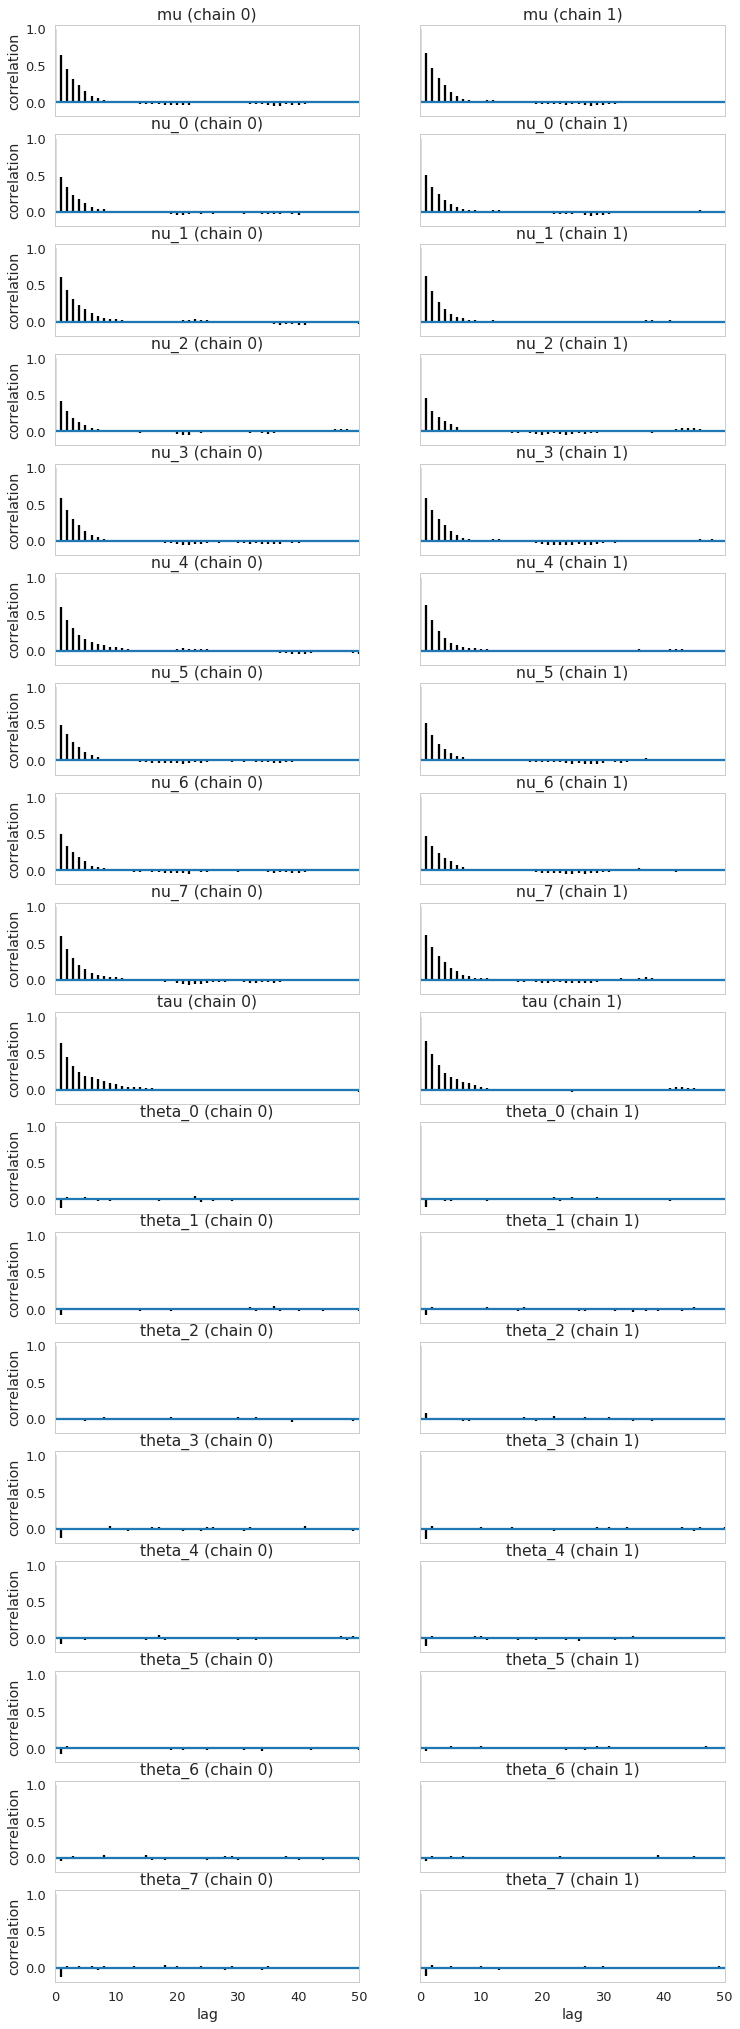

In [9]:
pm.autocorrplot(m1.t1, max_lag=50);

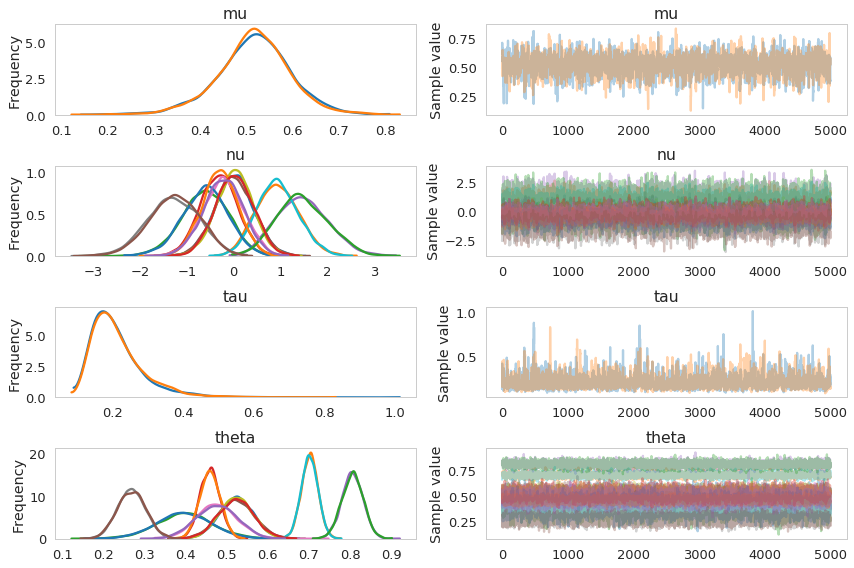

In [10]:
pm.traceplot(m1.t1);

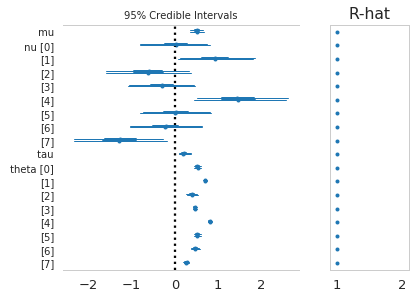

In [11]:
pm.forestplot(m1.t1);

In [12]:
print('Effective sample sizes')
print(pm.effective_n(m1.t1))

Effective sample sizes
{'mu': 1999.0, 'nu': array([ 2461.,  2048.,  2861.,  2132.,  1903.,  2463.,  2511.,  1935.]), 'tau': 1668.0, 'theta': array([ 10000.,  10000.,   8930.,  10000.,  10000.,  10000.,  10000.,
        10000.])}


The above tests indicate that the sampler converges well and autocorrelations are not too bad.

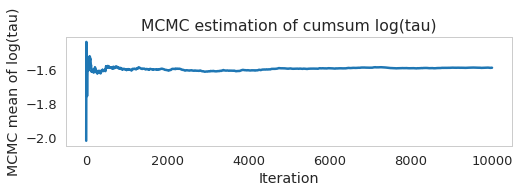

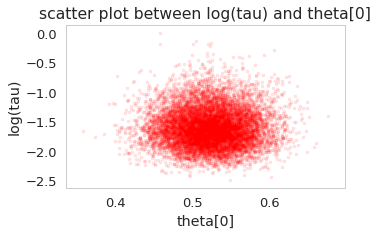

In [13]:
biasplot(m1.t1)
funnelplot(m1.t1)

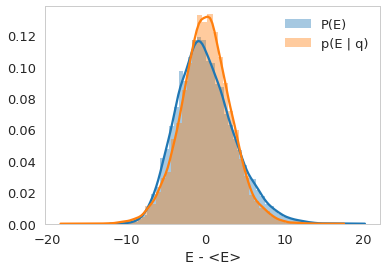

In [14]:
resample_plot(m1.t1)

The transition distribution matches the marginal energy distribution very well, which enables efficient generation of nearly independent samples.

### Answer to Part B

In [15]:
%%time
ms = [Model(dfs[i]).run() for i in range(len(dfs))]

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 7000/7000 [00:51<00:00, 136.29it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 7000/7000 [01:10<00:00, 98.92it/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 7000/7000 [00:48<00:00, 143.93it/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 7000/7000 [00:53<00:00, 130.33it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller th

CPU times: user 34.7 s, sys: 14.2 s, total: 48.9 s
Wall time: 15min 54s


The sampler converges well in most cases.

We can plot the estimates for the $\theta$'s against the values in the "mean" column (corresponding to this restaurant) as follows. Error bar represents 2-sigma envelop.

In [16]:
def get_theta(model):
    df = model.df
    df['theta_mean'] = 0
    df['theta_std'] = 0
    df.loc[df['topic']==0, 'theta_mean'] = model.t1['theta'].mean(axis=0)
    df.loc[df['topic']==1, 'theta_mean'] = model.t2['theta'].mean(axis=0)
    df.loc[df['topic']==0, 'theta_std'] = model.t1['theta'].std(axis=0)
    df.loc[df['topic']==1, 'theta_std'] = model.t2['theta'].std(axis=0)
    return model

for m in ms:
    get_theta(m)

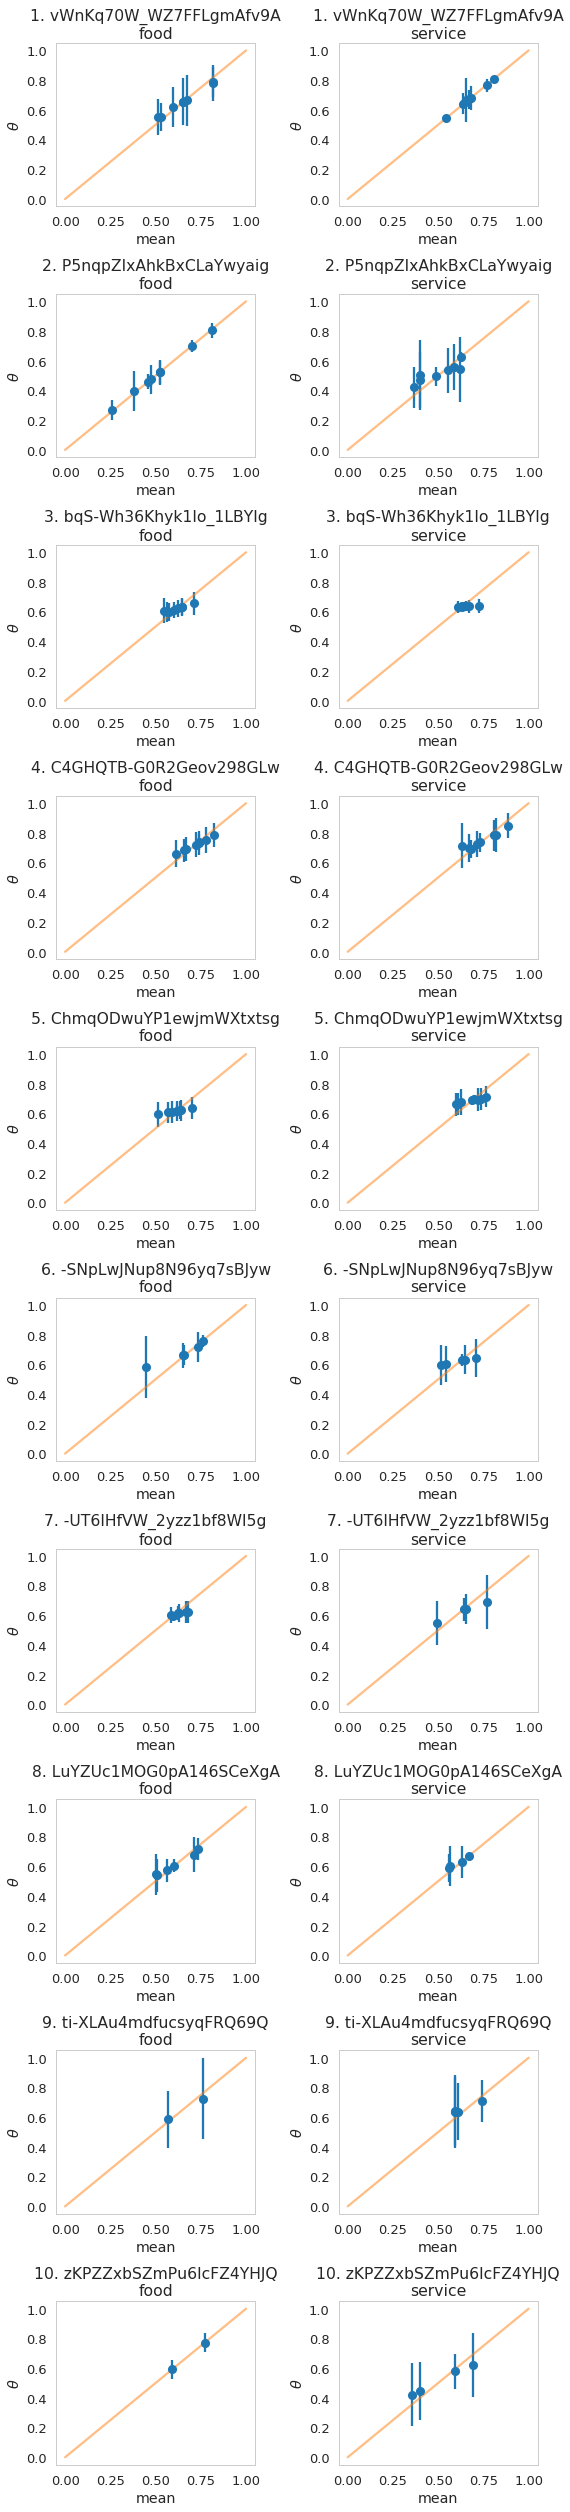

In [17]:
plt.figure(figsize=(8, 35))

for i in range(len(ms)):
    dfi = ms[i].df
    
    plt.subplot(10, 2, 2*i+1)
    plt.errorbar(dfi[dfi['topic']==0]['mean'], dfi[dfi['topic']==0]['theta_mean'], \
                 yerr=2*dfi[dfi['topic']==0]['theta_std'], fmt='o');
    plt.plot([0, 1], [0, 1], alpha=0.5);
    plt.xlabel('mean');
    plt.ylabel(r'$\theta$');
    plt.title(str(i+1) + '. ' + dfi['rid'].values[0] + '\nfood');
    
    plt.subplot(10, 2, 2*i+2)
    plt.errorbar(dfi[dfi['topic']==1]['mean'], dfi[dfi['topic']==1]['theta_mean'], \
                 yerr=2*dfi[dfi['topic']==1]['theta_std'], fmt='o');
    plt.plot([0, 1], [0, 1], alpha=0.5);
    plt.xlabel('mean');
    plt.ylabel(r'$\theta$');
    plt.title(str(i+1) + '. ' + dfi['rid'].values[0] + '\nservice');
plt.tight_layout();

Shrinkage is observed in most cases above.

We can plot the shrinkage plot and probability shrinkage plot for 10 restaurants as follows.

CPU times: user 4.7 s, sys: 93.8 ms, total: 4.8 s
Wall time: 4.84 s


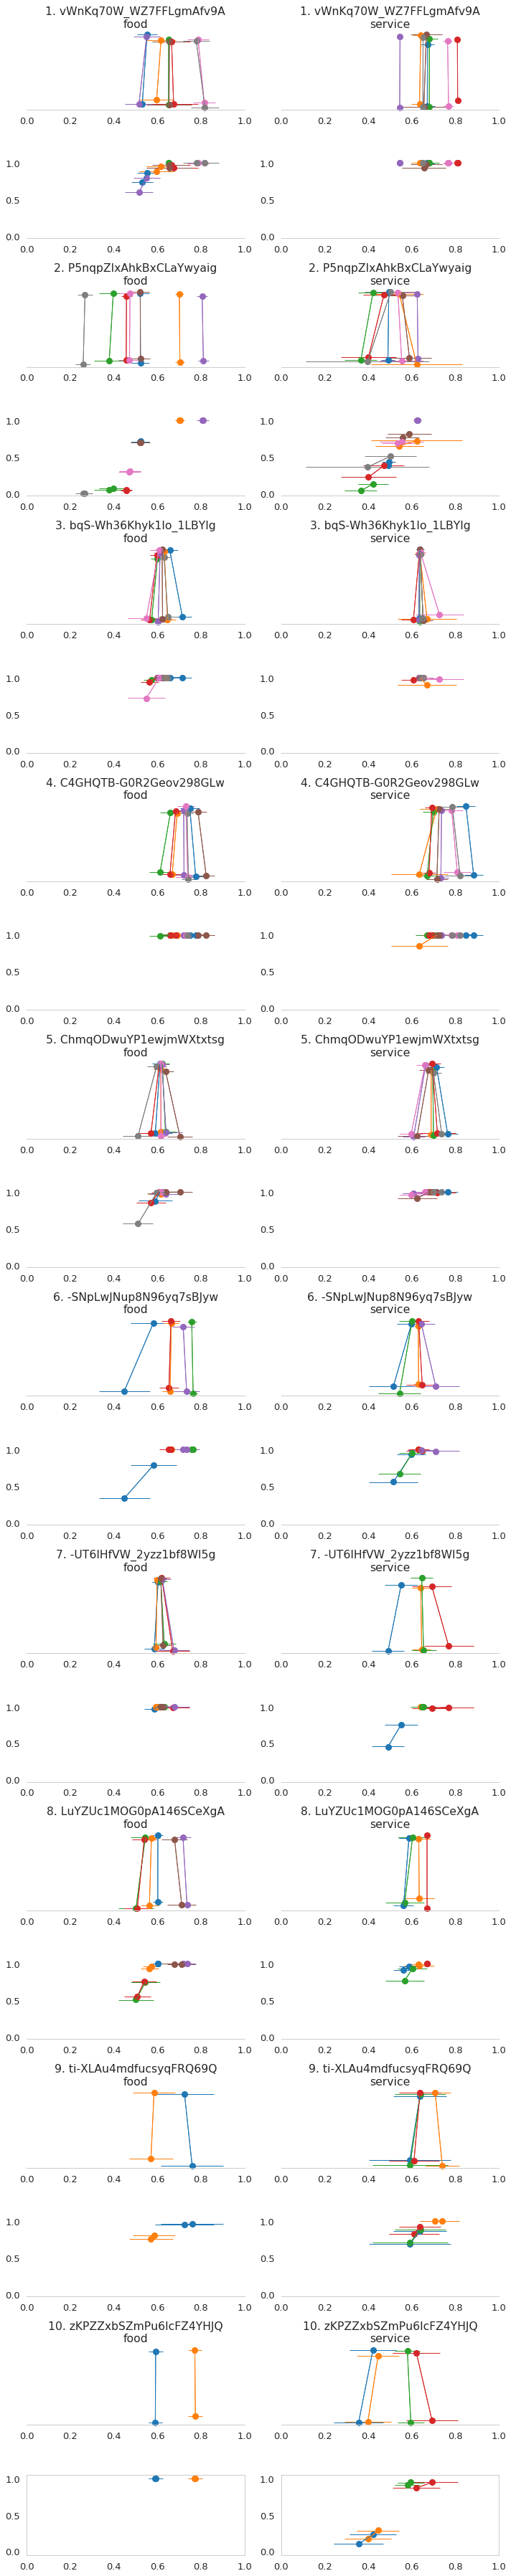

In [18]:
%%time

plt.figure(figsize=(10, 50))

for i in range(len(ms)):
    plt.subplot(20, 2, 4*i+1)
    splot(ms[i], 0)
    plt.title(str(i+1) + '. ' + ms[i].df['rid'].values[0] + '\nfood')
        
    plt.subplot(20, 2, 4*i+2)
    splot(ms[i], 1)
    plt.title(str(i+1) + '. ' + ms[i].df['rid'].values[0] + '\nservice')
    
    plt.subplot(20, 2, 4*i+3)
    psplot(ms[i], 0)
    #plt.title(ms[i].df['rid'].values[0] + '\nfood')
    
    plt.subplot(20, 2, 4*i+4)
    psplot(ms[i], 1)
    #plt.title(ms[i].df['rid'].values[0] + '\nservice')
    
plt.tight_layout();

The statistical benefits of modeling each reviewer's opinion using the model from Part A include:
1. The pooling effect makes the posterior mean shrink to the prior distribution; as a result, the inference is less sensitive to outliers in data.
2. The classification probabilities of posteriors would be higher (in most cases) than those from the sample means.

### Answer to Part C

We can simply average the posterior $\theta$'s to get food and service scores.

In [19]:
def get_theta(model):
    df = model.df
    df['theta_mean'] = 0
    df['theta_std'] = 0
    df.loc[df['topic']==0, 'theta_mean'] = model.t1['theta'].mean(axis=0)
    df.loc[df['topic']==1, 'theta_mean'] = model.t2['theta'].mean(axis=0)
    df.loc[df['topic']==0, 'theta_std'] = model.t1['theta'].std(axis=0)
    df.loc[df['topic']==1, 'theta_std'] = model.t2['theta'].std(axis=0)
    return model

def get_theta_mean(ms):
    records = []
    for m in ms:
        df = m.df
        records.append((m.df['rid'].values[0], df.loc[df['topic']==0, 'theta_mean'].mean(), \
                        df.loc[df['topic']==1, 'theta_mean'].mean()))
    labels = ['rid', 'food', 'service']
    return pd.DataFrame.from_records(records, columns=labels)\
.sort_values(by=['food', 'service'], ascending=False)

We can rank the restaurants by food score and then by service score as follows.

In [20]:
for m in ms:
    get_theta(m)

df_mean = get_theta_mean(ms)
df_mean

,rid,food,service
3,C4GHQTB-G0R2Geov298GLw,0.719873,0.748012
9,zKPZZxbSZmPu6IcFZ4YHJQ,0.682298,0.516845
5,-SNpLwJNup8N96yq7sBJyw,0.677091,0.620861
0,vWnKq70W_WZ7FFLgmAfv9A,0.657502,0.678802
8,ti-XLAu4mdfucsyqFRQ69Q,0.654968,0.655130
2,bqS-Wh36Khyk1lo_1LBYIg,0.620162,0.636858
4,ChmqODwuYP1ewjmWXtxtsg,0.616436,0.686607
6,-UT6IHfVW_2yzz1bf8WI5g,0.612889,0.632408
7,LuYZUc1MOG0pA146SCeXgA,0.609521,0.623071
1,P5nqpZIxAhkBxCLaYwyaig,0.518734,0.518839


Statisticla weakness of ranking by these scores:
1. Scores for restaurants with few reviews can be very skewed.
2. The variance (uncertainty) of some reivews is large, indicating the mean score of these reviews might be less reliable than others; the simple aggregation doesn't take it into account.
3. The overall scores (without rounding) for food would be different for different restaurants in almost all cases; we are essentially ranking by food scores and ignoring service scores.
4. The model doesn't take into account the scores given by reviewers.
5. Some reviewers are easygoing, and tend to have more positive opinions; some reviewers are picky, and tend to have more negative opinions. The model doesn't take such factor into account.

### Answer to Extra Credit

**1. Propose a model addressing the weakness of your approach in Part C.**

Let $u_{ijk}$ be the predictor representing the user $j$'s sentiment tendency for topic $i$, and $r_k$ be the restaurant $k$'s overall quality score. Then for each restaurant $k$, we can build the following model:
$$u_{ijk} \sim \mathcal{N}(\bar{u}_j, 1)$$
$$r_k \sim \mathcal{N}(\bar{r}_k, \sigma_k)$$
$$\bar{\theta}_{ijk} \sim \mathcal{N}(\frac{1}{2}u_{ijk}+\frac{1}{2}r_k, \sigma_{\theta_{ijk}})$$
where $\bar{u}_j$ is the scaled quantity "uavg" in data, $\bar{r}_k$ can be estimated by the mean of "stars" quantity (scaled) in data, $\sigma_k$ can be estimated by $\sigma_k^2 = \frac{\sigma_{r_k}^2}{n_k}$ ($\sigma_{r_k}^2$ is the variance of scaled "stars" quantity for restaurant $k$, and $n_k$ is the number of reviews for restaurant $k$), $\theta_{ijk}$s are from models in previous parts, and $\bar{\theta}_{ijk}$ and $\sigma_{\theta_{ijk}}$ represent the mean and standard deviation for $\theta_{ijk}$s in each model from previous parts.

**2. Implement and use this combined model to estimate the overall quality of food and service for each restaurant.**

In [44]:
def process_df(df):
    df['stars_mean'] = ((df.groupby('review_id').mean()['stars']-1)/4).mean()
    df['stars_std'] = np.sqrt(((df.groupby('review_id').mean()['stars']-1)/4).var() / len(df.groupby('review_id').mean()))
    df['uavg_scaled'] = (df['uavg'] - 1) / 4
    return df

In [45]:
for m in ms:
    process_df(m.df)

In [46]:
class Model2:
    def __init__(self, m1):
        self.m1 = m1
        self.df = m1.df
        
    def setup(self, u_mean, r_mean, r_std, theta_mean, theta_std):
        with pm.Model() as model:
            u = pm.Normal('u', mu=u_mean, sd=1, shape=len(u_mean))
            r = pm.Normal('r', mu=r_mean, sd=r_std)
            obs = pm.Normal('obs', mu=0.5*u+0.5*r, sd=theta_std, observed=theta_mean)
        return model
    
    def run(self, N_sample=5000, tune=2000):
        df = self.df
        self.m = self.setup(df['uavg_scaled'].values, df['stars_mean'].values[0], df['stars_std'].values[0],\
                            df['theta_mean'].values, df['theta_std'].values)
        with self.m:
            self.t = pm.sample(N_sample, step=pm.NUTS(target_accept=.95), tune=tune)
        return self
        

In [47]:
%%time

m2s = [Model2(m).run() for m in ms]

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, u]
100%|██████████| 7000/7000 [00:44<00:00, 157.52it/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, u]
100%|██████████| 7000/7000 [00:30<00:00, 226.73it/s]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, u]
100%|██████████| 7000/7000 [00:34<00:00, 205.67it/s]
The acceptance probability does not match the target. It is 0.905462017785, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, u]
100%|██████████| 7000/7000 [00:15<00:00, 459.18it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, u]
100%|██████████| 7000/7000 [00:22<00:00, 306.85it/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess s

CPU times: user 13.3 s, sys: 6.41 s, total: 19.7 s
Wall time: 5min 6s


We can perform some tests for the model (say, for the first restaurant).

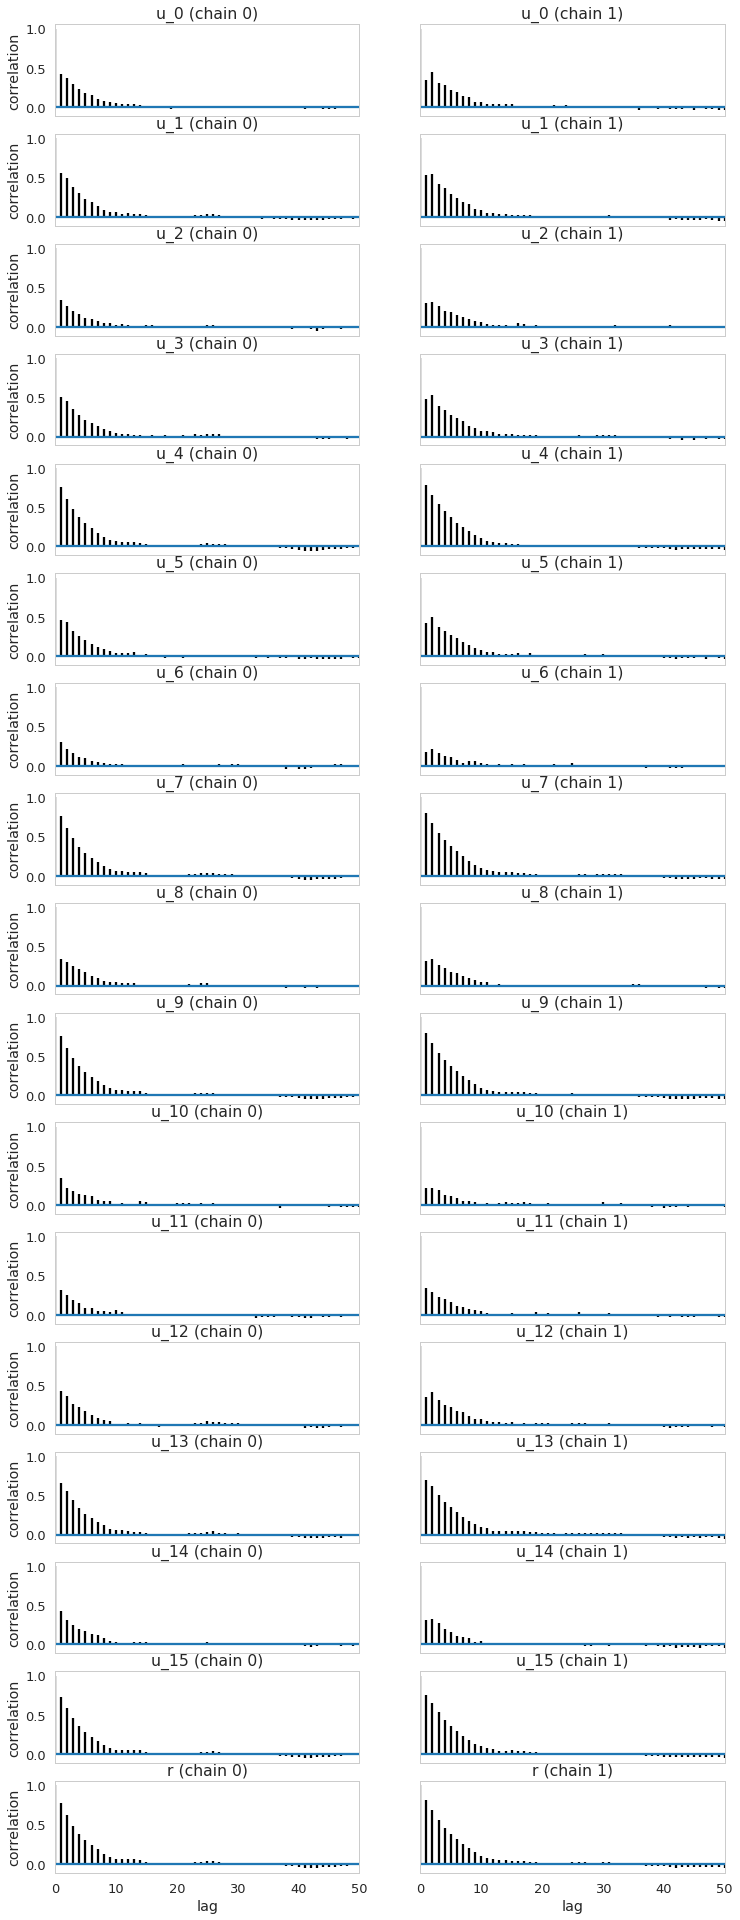

In [48]:
pm.autocorrplot(m2s[0].t, max_lag=50);

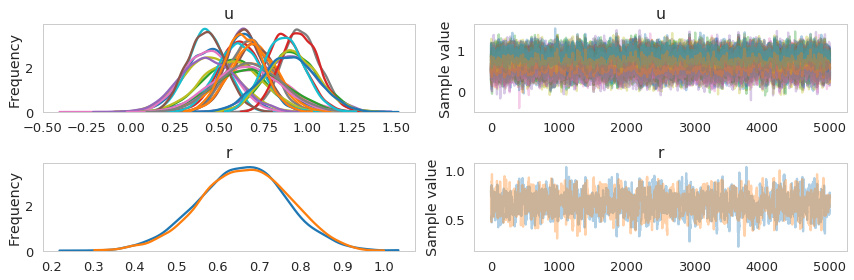

In [49]:
pm.traceplot(m2s[0].t);

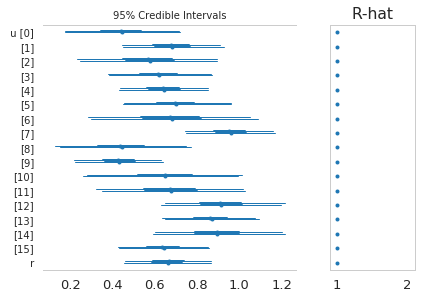

In [50]:
pm.forestplot(m2s[0].t);

In [51]:
print('Effective sample sizes')
print(pm.effective_n(m2s[0].t))

Effective sample sizes
{'u': array([ 1701.,  1345.,  2181.,  1416.,  1098.,  1589.,  2641.,  1074.,
        2095.,  1067.,  2387.,  2284.,  1914.,  1155.,  2098.,  1123.]), 'r': 1050.0}


The above tests indicate the sampler converges well, and the autocorrelations are not too bad.

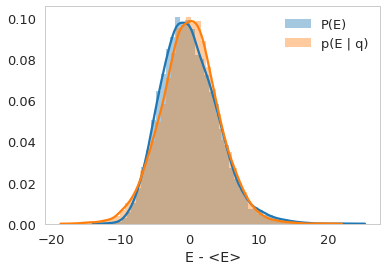

In [52]:
resample_plot(m2s[0].t)

The transition distribution matches the marginal energy distribution very well, which enables efficient generation of nearly independent samples.

We can plot the histogram of $r$'s in each model as follows.

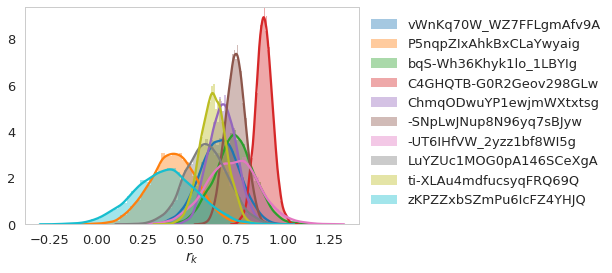

In [53]:
for m in m2s:
    sns.distplot(m.t['r'], norm_hist=True, label=m.df['rid'].values[0]);

plt.legend(bbox_to_anchor=(1, 1));
plt.xlabel('$r_k$');

In [54]:
def get_scores(m2s):
    records = []
    for m in m2s:
        df = m.df
        records.append((m.df['rid'].values[0], m.t['r'].mean(), m.t['r'].std()))
    labels = ['rid', 'score_mean', 'score_std']
    return pd.DataFrame.from_records(records, columns=labels)\
.sort_values(by=['score_mean'], ascending=False)

In [55]:
df_score = get_scores(m2s)

In [56]:
print('Ranking in Part C:')
df_mean

Ranking in Part C:


,rid,food,service
3,C4GHQTB-G0R2Geov298GLw,0.719873,0.748012
9,zKPZZxbSZmPu6IcFZ4YHJQ,0.682298,0.516845
5,-SNpLwJNup8N96yq7sBJyw,0.677091,0.620861
0,vWnKq70W_WZ7FFLgmAfv9A,0.657502,0.678802
8,ti-XLAu4mdfucsyqFRQ69Q,0.654968,0.655130
2,bqS-Wh36Khyk1lo_1LBYIg,0.620162,0.636858
4,ChmqODwuYP1ewjmWXtxtsg,0.616436,0.686607
6,-UT6IHfVW_2yzz1bf8WI5g,0.612889,0.632408
7,LuYZUc1MOG0pA146SCeXgA,0.609521,0.623071
1,P5nqpZIxAhkBxCLaYwyaig,0.518734,0.518839


In [57]:
print('New ranking:')
df_score

New ranking:


,rid,score_mean,score_std
3,C4GHQTB-G0R2Geov298GLw,0.900213,0.045138
5,-SNpLwJNup8N96yq7sBJyw,0.745796,0.053499
2,bqS-Wh36Khyk1lo_1LBYIg,0.742006,0.108085
6,-UT6IHfVW_2yzz1bf8WI5g,0.731055,0.140846
4,ChmqODwuYP1ewjmWXtxtsg,0.678661,0.074501
0,vWnKq70W_WZ7FFLgmAfv9A,0.661085,0.105409
8,ti-XLAu4mdfucsyqFRQ69Q,0.628163,0.070558
7,LuYZUc1MOG0pA146SCeXgA,0.591783,0.113620
1,P5nqpZIxAhkBxCLaYwyaig,0.413976,0.129275
9,zKPZZxbSZmPu6IcFZ4YHJQ,0.371310,0.169589


The order is different, but doesn't deviate too much from that in Part C for most restaurants. It is worth noting that ranking for some restaurants (e.g., restaurant 9) changes a lot; reasons include:
1. We applied "equal weights" to food and service in the new model, while we essentially ranked by food scores and ignored service scores in part C.
2. The priors that we used here have non-negligible effect on the results in the new model.